In [30]:
import numpy as np
import matplotlib.pyplot as plt
import emcee, corner, fsps
from cgs import *

%matplotlib inline

In [194]:
name,ra,dec,dist,mb,mberr,morph,EBV,FUV,FUVerr,NUV,NUVerr = [],[],[],[],[],[],[],[],[],[],[],[]
with open('ps5.txt','r') as f:
    for i,line in enumerate(f):
        if i == 0:
            next(f)
        else:
            l = line.split()
            l = [val.strip(', \n') for val in l]
            name.append(l[0])
            ra.append(l[1]+' '+l[2]+' '+l[3])
            dec.append(l[4]+' '+l[5]+' '+l[6])
            dist.append(float(l[7]))
            mb.append(float(l[8]))
            mberr.append(np.abs(np.random.normal(0,0.1)))
            morph.append(int(l[9]))
            EBV.append(float(l[10]))
            FUV.append(float(l[11]))
            FUVerr.append(float(l[12]))
            NUV.append(float(l[13]))
            NUVerr.append(float(l[14]))
        

In [253]:
FUV = np.asarray(FUV)
FUVerr = np.asarray(FUVerr)
mb = np.asarray(mb)
dist = np.asarray(dist)

# Problem 1

In [209]:
sp = fsps.StellarPopulation(imf_type = 2, zcontinuous = 1, logzsol = 0, sfh = 1, const = 1)

In [210]:
fsps.find_filter('uv')

['wfc3_uvis_f218w',
 'wfc3_uvis_f814w',
 'wfc3_uvis_f438w',
 'uvot_m2',
 'wfc3_uvis_f390w',
 'wfc3_uvis_f336w',
 'uvot_w2',
 'wfc3_uvis_f606w',
 'wfc3_uvis_f775w',
 'wfc3_uvis_f475w',
 'wfc3_uvis_f850lp',
 'wfc3_uvis_f225w',
 'galex_nuv',
 'galex_fuv',
 'uvot_w1',
 'wfc3_uvis_f555w',
 'wfc3_uvis_f275w']

In [211]:
fuv_sp = float(sp.get_mags(bands=['galex_fuv'],tage=13.7))
sfr_sp = float(sp.sfr)
print(fuv_sp,sfr_sp)

(6.846419917105074, 7.299270072992702e-11)


In [212]:
#find effective wavelength
wl = fsps.filters.get_filter('galex_fuv').lambda_eff #in angstroms
nu = c/(wl*1e-8) #in Hz
lognu = np.log10(nu)
print(lognu)

15.290984583


In [213]:
f0 = 3631e-23
M0 = -2.5*np.log10(f0)

f_nu = f0*10**(-0.4*fuv_sp)
d = 10*pc
L_nu = 4*np.pi*d**2*f_nu
logL = np.log10(L_nu)

In [214]:
Cfuv = lognu + logL - np.log10(sfr_sp)
print('The value of Cfuv I get is '+str(Cfuv))

The value of Cfuv I get is 43.3271651397


This is nearly exactly equal to the value in Kennicutt.  My result is smaller than his by a factor of 0.02 dex.  They could be slightly different because the Kennicutt result uses a different stellar model (starburst99) whereas we use the MIST models.

# Problem 2

In [351]:
b_sp = float(sp.get_mags(bands=['b'],tage=13.7))
L_sp = 10**(-0.4*b_sp)

In [352]:
b_sp = np.log10(L_sp)
print(b_sp)

-2.30160149015


Since FSPS outputs one solar mass in total of stars, this B-band magnitude is already normalized to per-solar-mass units.  So we can convert between mass and B-band magnitude using the following:
\begin{equation}
\log (M/M_\odot) = - M_B / 2.30
\end{equation}

The B-band is not that good a place to estimate stellar masses because (1) you aren't as sensitive to old, low-mass stars, (2) you're affected fairly strongly by extinction, and (3) the mass you get out depends on stellar models, which may be somewhat uncertain.

# Problem 3

In [353]:
def abs_mag(m,d):
    # d must be in parsecs
    return m - 5*(np.log10(d) - 1)

In [354]:
dist_red = dist[np.where(mb <= 99.0)]
mb_red = mb[np.where(mb <= 99.0)]
Mb_red = abs_mag(mb_red,dist_red*1.0e6)

Berg et al. (2012) give the relationship
\begin{equation}
12 + \log (\textrm{O}/\textrm{H}) = (6.27 \pm 0.21) + (-0.11 \pm 0.01) M_B
\end{equation}

In [355]:
z_red = 6.27 - Mb_red*0.11

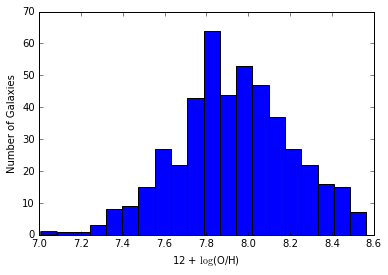

In [356]:
plt.hist(z_red,bins=20)
plt.ylabel(r'Number of Galaxies')
plt.xlabel(r'12 + $\log$(O/H)')
plt.show()

# Problem 4

In [357]:
#get a full sample taking out bad M_b and FUV points
dist_u = dist[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
mb_u = mb[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
FUV_u = FUV[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
Mb_u = abs_mag(mb_u,dist_u*1.0e6)
z_u = 6.27 - Mb_u*0.11

In [358]:
#Determine SFR_FUV for the sample using the Kennicutt prescription
f_nu_u = f0*10**(-0.4*FUV_u)
L_nu_u = 4*np.pi*(dist_u*1e6*pc)**2*f_nu_u
logL_u = np.log10(L_nu_u)

logsfr_fuv = logL_u + lognu - Cfuv

In [359]:
#figure out the error
FUV_err = FUVerr[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
frac_err = FUV_err/FUV_u
frac_err[frac_err >= 1] = 0.01
logsfr_err = logsfr_fuv*frac_err

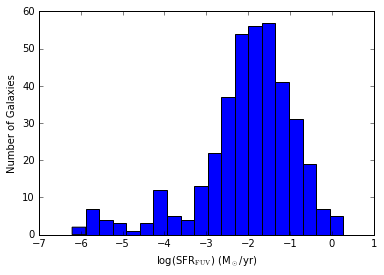

In [360]:
plt.hist(logsfr_fuv,bins=20)
plt.xlabel(r'log(SFR$_{\rm{FUV}}$) (M$_\odot$/yr)')
plt.ylabel('Number of Galaxies')
plt.show()

In [361]:
#determine M_star for the sample using the prescription from problem 2
Mstar_u = Mb_u/b_sp

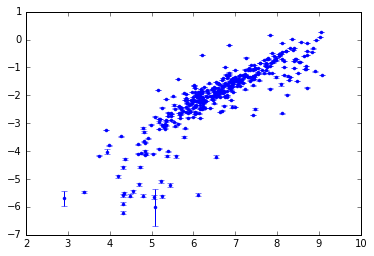

In [362]:
fig, ax = plt.subplots()
ax.errorbar(Mstar_u,logsfr_fuv,yerr=logsfr_err,linestyle='',marker='.')
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.show()

In [363]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b, lnf = theta
    if 0.1 < m < 2.0 and -20.0 < b < 0.0 and -10.0 < lnf < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 3, 100
pos = [[1.0,-10.0,0.0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Mstar_u, logsfr_fuv, logsfr_err))

In [364]:
sampler.run_mcmc(pos, 10000)

(array([[ 0.54863178, -5.56808314, -0.98995774],
        [ 0.5605021 , -5.65115572, -1.02655855],
        [ 0.57566168, -5.70961188, -0.92249851],
        [ 0.57405005, -5.7167639 , -1.01412362],
        [ 0.53985191, -5.44986649, -1.05399793],
        [ 0.52989551, -5.3899029 , -0.94610537],
        [ 0.58268962, -5.75774983, -0.94897613],
        [ 0.54907975, -5.54911973, -0.95648147],
        [ 0.58981804, -5.85222661, -0.94455038],
        [ 0.53727908, -5.41740669, -0.96233772],
        [ 0.53263758, -5.43166051, -0.97066361],
        [ 0.58067227, -5.75647106, -0.98707379],
        [ 0.54591488, -5.51239284, -1.01169357],
        [ 0.56587348, -5.67049057, -1.03743333],
        [ 0.54487078, -5.51691326, -0.96189812],
        [ 0.55541387, -5.60854096, -0.96587465],
        [ 0.55616137, -5.56949432, -0.95365403],
        [ 0.5436065 , -5.43292794, -0.92174368],
        [ 0.53183505, -5.32562088, -0.91450618],
        [ 0.56888789, -5.70781682, -1.008891  ],
        [ 0.56698918

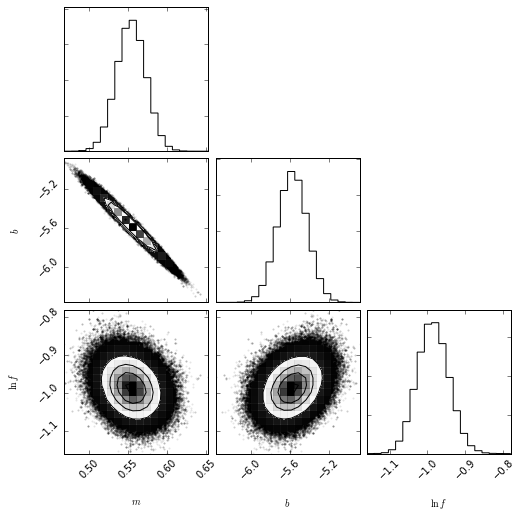

In [365]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"]) #truths=[m_true, b_true, np.log(f_true)])

The best-fit slope is around 0.56 and the best-fit intercept is around -5.6, so we have

log(SFR$_\textrm{FUV}$ [M$_\odot$ yr$^{-1}$]) = 0.56 log(M/M$_\odot$) - 5.6

In [366]:
nsamp = len(samples)
print(nsamp)

950000


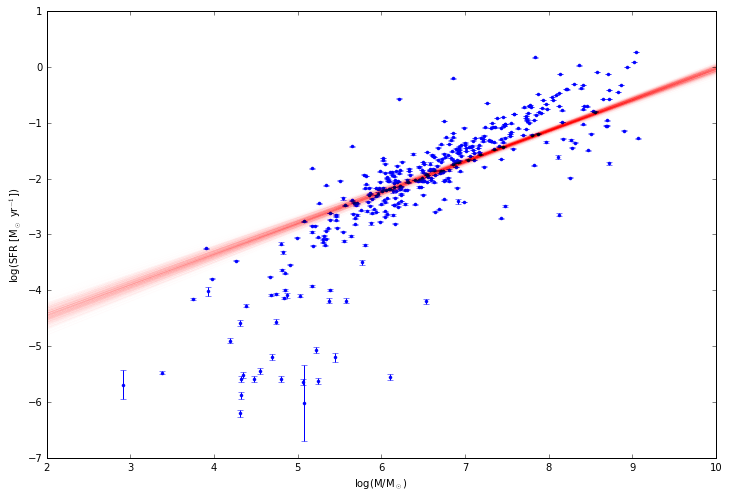

In [374]:
fig, ax = plt.subplots(figsize=(12.0,8.0))
ax.errorbar(Mstar_u,logsfr_fuv,yerr=logsfr_err,linestyle='',marker='.')

xs = ax.get_xlim()

for j in range(1000):
    spl = samples[np.random.randint(0,nsamp)]
    thism = spl[0]
    thisb = spl[1]
    ax.plot([xs[0],xs[1]],[thism*xs[0]+thisb,thism*xs[1]+thisb],color='red',linestyle='-',alpha = 0.003)

 
ax.set_ylabel(r'log(SFR [M$_\odot$ yr$^{-1}$])')
ax.set_xlabel(r'log(M/M$_\odot$)')
plt.show()

# Problem 5

There are a few model dependencies.  First, we used stellar population synthesis code to compute FUV luminosity per stellar mass.  The models themselves are probably accurate to first order, but may introduce error.  More worryingly, we must assume a constant star formation rate over the entire history of the population and a solar metallicity, both of which are probably not correct to some degree.  A full parameter space study would be necessary to disentangle the effects of these.  Second, estimating stellar masses from B-band magnitudes is highly uncertain as explained in Problem 2.  Finally, the luminosity-metallicity relationship is uncertain and has intrinsic scatter.  This makes it more difficult to determine whether a Solar metallicity is acceptable, and the size of the parameter space we'd need to cover for a more detailed analysis is not well defined.

Making significant improvements is difficult without resolved stellar population studies to understand star formation histories.  However, a better sampling of the power spectrum with photometry would also be useful.  In particular, stellar masses are better tracked by infrared emission especially in old systems.  H$\alpha$ spectra would also be a good check of the star formation rates, as this feature is a good tracer of SFR except at extremely low metallicity.